### Dog Adoption Predictor

Using a data set from Austin Animal Center (https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Outcomes/9t4d-g238/about_data), I will build a classifier to predict dog adoptions. I have already created a subset of the original data to minimize storage and to focus on attributes that I want to further analyze. To be specific, I'm interested to see if age and breed are relevant factors in making decisions leading to dog adoption.

To begin the analysis, I'm importing relevant libraries and load the 'Austin_Animal_Center_Outcomes_subset.csv' dataset.

In [1]:
## import libraries
import pandas as pd # data manipulation
import seaborn as sns # visualization
from sklearn.model_selection import train_test_split # split data set 
from sklearn.linear_model import LogisticRegression # predictor

## load and read data
data = pd.read_csv('Austin_Animal_Center_Outcomes_subset.csv')
## copy original data and remove rows with missing data 
df = data.copy()
df = df.dropna()
df.head()

,Outcome Type,Animal Type,Age upon Outcome,Breed
0,Rto-Adopt,Cat,2 years,Domestic Shorthair Mix
1,Adoption,Dog,1 year,Chihuahua Shorthair Mix
2,Euthanasia,Other,1 year,Raccoon
3,Adoption,Dog,4 months,Anatol Shepherd/Labrador Retriever
4,Transfer,Cat,6 days,Domestic Shorthair Mix


Given the data above, we can see that under the column 'Animal Type', other animals aside from "Dog" are included. I'll filter this column and remove rows with data other than the target type. 

In [2]:
## filter 'Dog' Animal type
df_dog = df.loc[df['Animal Type'] == "Dog"]
df_dog.iloc[10:20]

,Outcome Type,Animal Type,Age upon Outcome,Breed
27,Adoption,Dog,9 years,Chihuahua Shorthair Mix
29,Transfer,Dog,10 years,Yorkshire Terrier Mix
30,Return to Owner,Dog,1 year,Jack Russell Terrier/Chihuahua Shorthair
32,Return to Owner,Dog,8 years,Great Pyrenees Mix
35,Adoption,Dog,10 years,Chihuahua Shorthair
36,Return to Owner,Dog,3 years,Australian Cattle Dog Mix
37,Adoption,Dog,2 years,Beagle Mix
38,Adoption,Dog,2 months,Labrador Retriever Mix
39,Adoption,Dog,2 years,Labrador Retriever/Staffordshire
42,Adoption,Dog,7 months,Pit Bull Mix


Next, we are interested only whether a dog is adopted or not. Under the column 'Outcome Type' above, all datapoints with the word "Adopt" are assigned to number 1, and everything else is assigned the number 0.

In [3]:
## change 'Outcome Type' to either:
## 0 - not adopted
## 1 - adopted
mask = df_dog['Outcome Type'].str.contains('Adopt')
print('adoption count:')
print("not adopted =", len(~mask[~mask]))
print("adopted =", len(mask[mask]))

df_adopt = df_dog.copy() 
df_adopt.loc[~mask, 'Outcome Type'] = 0
df_adopt.loc[mask, 'Outcome Type'] = 1
df_adopt.iloc[10:20]

adoption count:
not adopted = 44191
adopted = 44926


,Outcome Type,Animal Type,Age upon Outcome,Breed
27,1,Dog,9 years,Chihuahua Shorthair Mix
29,0,Dog,10 years,Yorkshire Terrier Mix
30,0,Dog,1 year,Jack Russell Terrier/Chihuahua Shorthair
32,0,Dog,8 years,Great Pyrenees Mix
35,1,Dog,10 years,Chihuahua Shorthair
36,0,Dog,3 years,Australian Cattle Dog Mix
37,1,Dog,2 years,Beagle Mix
38,1,Dog,2 months,Labrador Retriever Mix
39,1,Dog,2 years,Labrador Retriever/Staffordshire
42,1,Dog,7 months,Pit Bull Mix


Now, I'll aggregate the 'Age upon Outcome' column into 3 groups:

[0] puppy: 0-2 years old

[1] young adult: 3-7 years old

[2] senior: 7+ years old

I based the grouping on average statistics of the all the dog breeds which age differently based on their size. 


In [4]:
# group with respect to age categories
mask_pup = df_adopt['Age upon Outcome'].str.contains('d|w|m|1 y|2 y')
mask_mid = df_adopt['Age upon Outcome'].str.contains('3 y|4 y|5 y|6 y|7 y')
mask_senior = ~(mask_pup | mask_mid)
## assign groups
df_age = df_adopt.copy()
df_age.loc[mask_pup, 'Age upon Outcome'] = 0
df_age.loc[mask_mid, 'Age upon Outcome'] = 1
df_age.loc[mask_senior, 'Age upon Outcome'] = 2
df_age.iloc[10:20]

print('age group counts:')
print("puppy =", len(mask_pup[mask_pup]))
print("young adult =", len(mask_mid[mask_mid]))
print("senior =", len(mask_senior[mask_senior]))

df_age.iloc[10:20]

age group counts:
puppy = 63161
young adult = 20960
senior = 4996


,Outcome Type,Animal Type,Age upon Outcome,Breed
27,1,Dog,2,Chihuahua Shorthair Mix
29,0,Dog,2,Yorkshire Terrier Mix
30,0,Dog,0,Jack Russell Terrier/Chihuahua Shorthair
32,0,Dog,2,Great Pyrenees Mix
35,1,Dog,2,Chihuahua Shorthair
36,0,Dog,1,Australian Cattle Dog Mix
37,1,Dog,0,Beagle Mix
38,1,Dog,0,Labrador Retriever Mix
39,1,Dog,0,Labrador Retriever/Staffordshire
42,1,Dog,0,Pit Bull Mix


Next, the 'Breed' column needs to cleaned as well. First, I'll omit the 2nd breed for mixed breeds (separated by a slash character). Second, breeds with less than 300 data points won't be considered for this analysis. Third, all remaining breeds will be renamed and combined if they are alike. Lastly, each breed will be given a label from 0-24 based on a dictionary I wrote below.

In [5]:
## omit the 2nd breed for mixed breeds
df_breed = df_age.copy()
df_breed['Breed'] = df_breed['Breed'].str.split('/').str[0]

## remove breeds that has less than 300 data points
print('number of breeds considered before and after data cleaning:')
print('initial breed count =', len(df_breed['Breed'].unique()))
temp = df_breed['Breed'].value_counts() > 300
df_breed = df_breed[df_breed['Breed'].isin(temp[temp].index.get_level_values(0).values)]

## categorize breeds using a dictionary
breed_category_dict = {
              0:'Pit Bull',
              1:'Retriever',
              2:'Chihuahua',
              3:'Shepherd',
              4:'Maltese',
              5:'Pug',
              6:'Cattle Dog',
              7:'Husky',
              8:'Poodle',
              9:'Dachshund',
              10:'Boxer',
              11:'Border Collie',
              12:'Terrier',
              13:'Pyrenees',
              14:'Staffordshire',
              15:'Beagle',
              16:'Schnauzer',
              17:'Pointer',
              18:'Catahoula',
              19:'Bulldog',
              20:'Rottweiler',
              21:'Cur',
              22:'Hound',
              23:'Kelpie',
              24:'Shih Tzu'
}
## inverse breed dict
breed_dict_inv = {v:k for k, v in breed_category_dict.items()}

## rename and group similar breeds
def rename_breed(breed_name, breed_dict_inv):
    ## breed set
    breed_set = breed_dict_inv.keys()
    for k in breed_set:
        if k in breed_name:
            return k
    return breed_name        
df_breed['Breed'] = df_breed['Breed'].apply(lambda x: rename_breed(x, breed_dict_inv))    

## categorize breeds
df_breed['Breed_label'] = df_breed['Breed'].map(breed_dict_inv)
print('final breed count =', len(df_breed['Breed'].unique()))

## drop 'Animal Type' and rename columns
df_breed = df_breed.rename(columns={'Outcome Type':'Adopt', 'Age upon Outcome':'Age'}) \
            .drop('Animal Type', axis=1).reset_index(drop=True)
df_breed.head(10)

number of breeds considered before and after data cleaning:
initial breed count = 397
final breed count = 25


,Adopt,Age,Breed,Breed_label
0,1,0,Chihuahua,2
1,1,1,Chihuahua,2
2,1,0,Border Collie,11
3,0,0,Pit Bull,0
4,0,0,Chihuahua,2
5,0,0,Retriever,1
6,1,0,Cur,21
7,1,2,Chihuahua,2
8,0,2,Terrier,12
9,0,0,Terrier,12


Now that the data is clean, let's visualize and see some statistics of adoption with respect to age and breed.

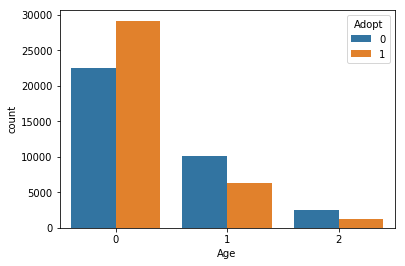

In [6]:
## plot counts for adoption among age groups
sns.countplot(data=df_breed, x="Age", hue="Adopt")

From the plot above, we can observe that dogs of ages less than 2 years old are likely to be adopted more than the other age groups.

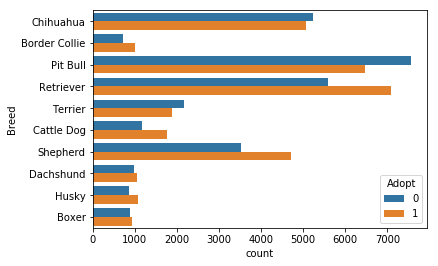

In [7]:
## plot counts for adoption among breed groups
## to make it simple, let's plot the top 10 breeds in terms of number of data points
top_breeds = df_breed['Breed'].value_counts().nlargest(10)
df_top_breeds = df_breed.loc[df_breed['Breed'].isin(top_breeds.index)]
sns.countplot(data=df_top_breeds, y="Breed", hue="Adopt")

This time, we can see from the plot that there's a bias against adopting Pit Bulls and for adopting Retrievers. Based on this data, we can assume that personal beliefs and opinions with respect to a breed's reputation affect decisions in adoption. 

Now that we confirmed both factors age and breed are relevant attributes, we will be using them to build a predictor based on a logistic regression model. This is a great model to use for classification problems.

To begin, I'll split the data into training and test sets:

In [8]:
 ## split data into test and training sets
X = df_breed[['Age', 'Breed_label']] 
y = df_breed['Adopt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("number of data points per set:")
print("train = ", len(y_train))
print("test = ", len(y_test))

number of data points per set:
train =  50435
test =  21615


Then, I'll use the training set from above to train the classifier.

In [9]:
## train classifier
clf = LogisticRegression(solver='lbfgs', random_state=0).fit(X_train, y_train.astype('int'))

Finally, let's test the classifier with some of our test data:

In [10]:
## get accuracy metric with respect test data
print("Logistic Regression classifier accuracy =", clf.score(X_test, y_test.astype('int')))

## predict some test data points
test = X_test[:10].copy()
out = clf.predict(test)
test['Breed'] = test['Breed_label'].map(breed_category_dict)
test['Adopt'] = y_test[:10]
test['Predict'] = out
test

Logistic Regression classifier accuracy = 0.5799676150821189


,Age,Breed_label,Breed,Adopt,Predict
56262,0,17,Pointer,1,1
69480,1,3,Shepherd,0,0
30542,0,0,Pit Bull,1,1
9128,0,0,Pit Bull,1,1
5564,0,3,Shepherd,1,1
19284,0,2,Chihuahua,1,1
12001,1,1,Retriever,0,0
43627,1,19,Bulldog,1,0
11550,1,0,Pit Bull,1,0
8153,1,6,Cattle Dog,1,0


From the results above, the classifier has an accuracy of 58%. In addition, we can see from the table that 3 out 10 data points were misclassified which are young adult dogs with breeds of Bulldog, Pit Bull, and Cattle Dog. This misclassification can be accounted to the 'Age' attribute having a stronger weight in terms of predicting adoption.

To improve the model and for further research, other attributes can be added to the model such as housing situation and ratio of families with children around the area.